# 実験を開始する

実験パッケージを用意して実験の開始をサポートします。  
上から順番に実行してください。  
2回目以降の実行では、画面上部に表示される以下のボタンをクリックしてから実行して下さい。
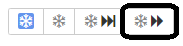

## 1. 実験用リポジトリの作成、リポジトリ名の入力、実験の入力データの設定を行う

ここでは [データガバナンス機能](http://dg02.dg.rcos.nii.ac.jp/)と連携して、あなたの  
実験用リポジトリを作成します。以下を順番に実行してください。

### - 1.1 作成したいリポジトリ名を入力する

以下のセルを実行し、表示されるテキストボックスに作成したいリポジトリの名前を入力してください。  
※もし入力値に誤りがあった場合、もう一度実行することで訂正ができます。

In [ ]:
from IPython.display import clear_output
repository_title = input("リポジトリ名：")
clear_output()
print("作成したリポジトリ名：",repository_title)

### - 1.2 この実験の入力データを既存の実験の出力データからコピーしたい場合は以下を実行する

以下のセルを実行して、この実験の入力データとしたい出力データを持つ既存実験のリポジトリをセレクトボックスから選択してください。  
※入力データのコピーが不要であれば、この手順をスキップして2.に進んでください。

In [ ]:
from ipywidgets import Select, Button
from IPython.display import clear_output

# 実験リポジトリ名を取得する
import os
path = '/home/jovyan/experiments'
files = os.listdir(path)
files_dir = [f for f in files if os.path.isdir(os.path.join(path, f)) and f != '.ipynb_checkpoints']

# セレクトボックスで選択された実験リポジトリ名をex_repoに格納する
def on_click_callback(clicked_button: Button) -> None:
    global ex_repo
    ex_repo = select.value

button = Button(description='選択完了')
select = Select(options=files_dir)
button.on_click(on_click_callback)
display(select, button)

## 2. 実験環境を整える

先ほど入力いただいた名前の実験用リポジトリをデータガバナンス機能に作成します。  
そのために、以下のセルを実行し、表示されるテキストボックスにデータガバナンス機能の  
ユーザ名とパスワードを入力してください。この情報は認証のために利用します。

In [ ]:
import json
import os
os.chdir('..')

from util.scripts import utils

# 以下の認証の手順で用いる、
# GINのドメイン名等をパラメタファイルから取得する
params = {}
with open(utils.fetch_param_file_path(), mode='r') as f:
    params = json.load(f)

In [ ]:
# リポジトリ作成のためのユーザ認証
import os
import time
import getpass
import requests

from IPython.display import clear_output
from requests.auth import HTTPBasicAuth
from http import HTTPStatus

# 正常に認証が終わるまで繰り返し
while True:
    name = input("ユーザー名：")
    password = getpass.getpass("パスワード：")
    clear_output()
    
    # GIN API Basic Authentication
    # refs: https://docs.python-requests.org/en/master/user/authentication/
    
    # 既存のトークンがあるか確認する
    response = requests.get(params['siblings']['ginHttp']+'api/v1/users/' + name + '/tokens', auth=(name, password))
    tokens = response.json()

    # 既存のトークンがなければ作成する
    if len(tokens) < 1:
        response = requests.post(params['siblings']['ginHttp']+'api/v1/users/' + name + '/tokens', data={"name": "system-generated"} ,auth=(name, password))

    if response.status_code == HTTPStatus.OK or HTTPStatus.CREATED:
        tokens = response.json()
        clear_output()
        print("認証が正常に完了しました。次の手順へお進みください。")
        break
    else:
        clear_output()
        print("ユーザ名、またはパスワードが間違っています。\n恐れ入りますがもう一度ご入力ください。")

In [ ]:
# GIN APIでリポジトリを作成する
import requests

create_repo = requests.post(
                # FIXME: ドメイン名のハードコーディング
                params['siblings']['ginHttp']+'api/v1/user/repos?token=' + tokens[0]['sha1'],
                data={
                    "name": repository_title,
                    "auto_init": False
                }
                )
print(create_repo)

### - 2.1 実験用のサブデータセットを作る

In [ ]:
remote_url = params['siblings']['ginSsh']+name+'/'+repository_title+'.git'

%cd /home/jovyan/experiments
!datalad create -d /home/jovyan ./$repository_title

In [ ]:
# !datalad create ~/.tmp/$repository_title
# remote_url = params['siblings']['ginSsh']+name+'/'+repository_title+'.git'

# !cd ~/experiments
# # !datalad clone -d /home/jovyan $remote_url
# !datalad install $remote_url
!cd /home/jovyan/experiments/$repository_title
!datalad siblings add -d $repository_title -s gin --url $remote_url
!cp -r ~/WORKFLOW/PACKAGE/. ~/experiments/$repository_title

In [ ]:

# datalad create ~/.tmp/$repository_title
# cp -r ~/WORKFLOW/PACKAGE/. ~/.tmp/$repository_title/
# ex_repoが存在するなら、既存の実験の出力データをinput_dataにコピーする
try:
    ex_repo
    %cd /home/jovyan/experiments/$ex_repo
    !git pull
    %cd ~/
    !cp -r ~/experiments/$ex_repo/output_data/. ~/.tmp/$repository_title/input_data/
except:
    pass
%cd ~/.tmp/$repository_title
# !git add ~/.tmp/$repository_title
# !git commit -m '1st commit'
# !git remote add $repository_title $remote_url
# !git push $repository_title master
# !datalad save --to-git -m "1st commit"
# !datalad push

### - 2.4. pipeline.jsonに実験名を追記する

In [ ]:
import json

with open('/home/jovyan/experiments/pipeline.json', 'r') as f:
    pipeline = json.load(f)

pipeline.append(repository_title)

with open('/home/jovyan/experiments/pipeline.json', 'w') as f:
    json.dump(pipeline, f, indent = 4)

### - 2.5 このノートブックを保存する

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

### - 2.6 実行結果をデータガバナンス機能に反映する

In [ ]:
import papermill as pm

%cd ~/

pm.execute_notebook(
    'WORKFLOW/FLOW/util/base_datalad_save_push.ipynb',
    '/home/jovyan/.local/push_log.ipynb',
    parameters = dict(SAVE_MESSAGE = '実験用リポジトリの作成')#, PATH = '/home/jovyan/experiments/'+repository_title)
)

## 3. 実験リポジトリにアクセスして実験を開始する

以下のセルを実行した後に出力されるリンクをクリックして実験に移ってください。  
このリンクはデータガバナンス機能に作成した実験リポジトリのトップ画面にも表示されます。  

In [ ]:
import urllib

print(
    "https://binder.cs.rcos.nii.ac.jp/v2/git/" + urllib.parse.quote(remote_url, safe='') + "/HEAD?filepath=experiment.ipynb"
)

## 4.[FLOW](../FLOW.md)に戻る